# Classificando Fases Quânticas com ML

## Importando pacotes

In [33]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import normalize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
import warnings

fases = ['Haldane', 'Trimer', 'Ferro', 'Dimer', 'LD', 'XY1', 'Neel', 'XY2'] #Definir a ordem das fases
colors = ['red', 'purple', 'blue', 'green', 'yellow', 'cyan', 'olive', 'black'] #Definir cores de cada fase
###  LISTA DE CLASSIFICADORES QUE SERÃO UTILIZADOS  
classifiers = [
    KNeighborsClassifier(50), #knn
    SVC(kernel="rbf", C=0.025, probability=True),
    #NuSVC(probability=True),
    DecisionTreeClassifier(), #Árvore de Decisão
    MLPClassifier(alpha=1), #rede neural    
    RandomForestClassifier(), #Random Forest
    AdaBoostClassifier(),
    GradientBoostingClassifier(), #Gradient Boosting
    GaussianNB(), #Naive Bayes
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression() #Regressão Logística
]


* Haldane &#8594; $[0]$
* Trimer &#8594; $[1]$
* Ferro &#8594; $[2]$
* Dimer &#8594; $[3]$
* LD &#8594; $[4]$
* XY1 &#8594; $[5]$
* Neel &#8594; $[6]$
* XY2 &#8594; $[7]$

## Lendo os arquivos com os dados

In [34]:
dfXXZ = pd.DataFrame(pd.read_excel("dfXXZ_final.xls"))
dfXXZTeorico = pd.DataFrame(pd.read_csv('pontos_plot_XXZ.csv', header=None))
dfBond = pd.DataFrame(pd.read_excel("dfBond_final.xls"))
dfBondTeorico = pd.DataFrame(pd.read_csv('data_paper_ferro_bond.csv', header=None))
dfBilinear = pd.read_excel("dfBilinear_final.xls")
dfBilinearTeorico = pd.DataFrame([0.25, 0.5, 1.25, 1.75])

## Rotulando os dados

Nesta etapa estamos rotulando os dados teóricos nos quais o nosso algoritmo de ML se baseará para realizar as predições. Para tal, utilizaremos as fronteiras indicadas nos papers:
* [XXZ](https://arxiv.org/abs/cond-mat/0209403.pdf)
* [Bond](https://arxiv.org/pdf/cond-mat/9511122.pdf)
* [Bilinear](https://arxiv.org/pdf/1602.03731.pdf)

Criaremos polinômios que servirão para definir as fronteiras de cada fase, e assim teremos os nossos rótulos teóricos.

In [35]:
# ROTULAR XXZ
rotuladorXXZ = []
for x in range(0, len(dfXXZ)):
    X = dfXXZ.values[x, 0]
    y = dfXXZ.values[x, 1]

#     FASES FERRO/LD
    if X < -1.8375250:
        if y < (-0.1009)*(X**2) - 1.6701*X - 1.329:
            rotuladorXXZ.append(2)
        else:
            rotuladorXXZ.append(4)

#     FASES FERRO/XY
    elif X >= -1.837525 and X < -0.278:
        if y >-0.0741*X**3 - 0.3014*X**2 - 0.872*X + 0.3499:
            rotuladorXXZ.append(4)
        elif y < -5.1127*X**5 - 27.865*X**4 - 57.426*X**3 - 55.858*X**2 - 27.638*X - 6.4824:
            rotuladorXXZ.append(2)
        else:
            rotuladorXXZ.append(5)

    elif X >= -0.278 and X < 0:
        if y >-0.0741*X**3 - 0.3014*X**2 - 0.872*X + 0.3499:
            rotuladorXXZ.append(4)
        elif y < -5.1127*X**5 - 27.865*X**4 - 57.426*X**3 - 55.858*X**2 - 27.638*X - 6.4824:
            rotuladorXXZ.append(2)
        elif y < 4.595*X**2 + 1.393*X - 2.007:
            rotuladorXXZ.append(7)
        else:
            rotuladorXXZ.append(5)

#     FASES LD/ HALDANE
    elif X >= 0 and X < 3.28405:
        if y > 0.0807*X**2 + 0.5418*X + 0.3465:
            rotuladorXXZ.append(4)
        elif y > -0.0462*X**3 + 0.154*X**2 + 1.5213*X - 2.0196:
            rotuladorXXZ.append(0)
        else:
            rotuladorXXZ.append(6)

#     FASES LD/NEEL
    elif X >= 3.28405 and X <= 4:
        if y > 1.0906*X - 0.583:
            rotuladorXXZ.append(4)
        else:
            rotuladorXXZ.append(6)
dfXXZ["labels"] = rotuladorXXZ

######################################################################
# ROTULAR BOND
rotuladorBond = []
for x in range(0, len(dfBond)):
    X = dfBond.values[x, 0]
    y = dfBond.values[x, 1]

#     FASE FERRO
    if X < -1:
        rotuladorBond.append(2)

#     FASE XY/ DIMER
    elif X >= -1 and X < 0:
        if y > 0.1435*X**2 - 0.6447*X + 0.2197:
            rotuladorBond.append(3)
        else:
            rotuladorBond.append(5)

#     FASE HALDANE/DIMER
    elif X >= 0 and X < 1:
        if y > 0.0043*X**3 - 0.0384*X**2 + 0.0631*X + 0.2317:
            rotuladorBond.append(3)
        else:
            rotuladorBond.append(0)   

#     FASE HALDANE/NEEL
    elif X >= 1.0 and X <= 1.2:
        if y > -0.0872*X**2 + 0.6067*X - 0.2264:
            rotuladorBond.append(3)
        elif y > -247.1*X**3 + 826.12*X**2 - 921.85*X + 343.48:
            rotuladorBond.append(6)
        else:
            rotuladorBond.append(0)

#     FASE NEEL/DIMER
    elif X > 1.2 and X <= 2.5:
        if y > -0.0872*X**2 + 0.6067*X - 0.2264:
            rotuladorBond.append(3)
        else:
            rotuladorBond.append(6)

rotuladorBondDF = pd.DataFrame(rotuladorBond)
dfBond["labels"]= rotuladorBondDF

######################################################################
# ROTULAR BILINEAR

rotuladorBilinear = []
zeros = []
yf = list()
for k in range(0, len(dfBilinear)):
    yf.append(0)
for x in range(0, len(dfBilinear)):
#     FASE HALDANE
    if dfBilinear.values[x,0] <= 0.25 and dfBilinear.values[x,0] >= 0 or dfBilinear.values[x,0] > 1.75 and dfBilinear.values[x,0] <= 2:
        rotuladorBilinear.append(0)
#     FASE TRIMER
    elif dfBilinear.values[x,0] > 0.25 and dfBilinear.values[x,0] <= 0.5:
        rotuladorBilinear.append(1)
#     FASE FERRO
    elif dfBilinear.values[x,0] > 0.5 and dfBilinear.values[x,0] <= 1.25:
        rotuladorBilinear.append(2)
#     FASE DIMER
    else:
        rotuladorBilinear.append(3)

dfBilinear["labels"]= pd.DataFrame(rotuladorBilinear)

## Criando Funções para Aplicar e plotar o ML

Iremos criar funções para evitar repetir muitos processos iguais no código. A princípio pode parecer mais complicado, porém torna o código mais organizado e MUITO mais curto. Optei por fazer em duas funções (gerar os dados/ plotar) para que pudesse reaproveitar a primeira na hora de calcular a precisão variando o valor de K. Uma ideia útil e fácil de ser implementada é adicionar uma outra variável de entrada na função - o classificador utilizado. É possível colocar até mesmo uma lista de classificadores e testar diferentes métodos de ML praticamente sem alterar o código.

In [36]:
def aplicarMLTransfer(dfTreino1, dfTreino2, dfTeste, dfTeorico, classifier, listaNumeroFasesIgnorar=[]):#Função a ser criada
    
    warnings.filterwarnings('ignore') #Ignorando avisos
    
    X_train = pd.DataFrame(normalize(dfTreino1.values[:,2:-1])).append(pd.DataFrame(normalize(dfTreino2.values[:, 2:-1]))) #Juntando os datasets de treino

    #print(X_train.head())

    y_train = pd.DataFrame(dfTreino1.labels).append(pd.DataFrame(dfTreino2.labels))#Juntando os rótulos dos datasets de treino
    X_test = pd.DataFrame(dfTeste.values[:, :]).rename(columns={27:"labels"})#Pegando o dataset de teste

    for i in listaNumeroFasesIgnorar:
        X_test = pd.DataFrame(X_test[X_test.labels != i])#Ignorando as fases desejadas
    y_test = X_test.labels#Pegando os rótulos de teste
    
    classifier.fit(X_train, y_train)#Fitando o cklassificador nos dados de treino
    previsao = classifier.predict(normalize(pd.DataFrame(X_test.values[:, 2:-1])))#Prevendo os rótulos de teste
    precisao = accuracy_score(y_test, previsao) #Obter a precisao do classificador
    X_test[classifier.__class__.__name__] = previsao #Adicionando os rótulos que o classificador atribuiu ao dataset de teste - será importante para os plots depois    

    return X_test, precisao #Esta função retorna o dataframe de teste e a precisão obtida

def plotsMLTransfer(dfTreino1, dfTreino2, dfTeste, dfTeorico, classifier, listaNumeroFasesIgnorar=[]): #Criar função para plotar os gráficos obtidos na função acima
    
    X_test, precisao = aplicarMLTransfer(dfTreino1,dfTreino2,dfTeste, dfTeorico, classifier, listaNumeroFasesIgnorar) #Chama a função acima
    
    name = classifier.__class__.__name__
    print(name + ' - Precisão: ', precisao) #Escreve a precisao na tela   
    for i in range(0,8):#Varia de 0 a 8 pois é o número de fases
        plt.scatter(X_test[0][X_test[name]==i], X_test[1][X_test[name]==i], label = fases[i], color = colors[i])#Plota todos os dados contidos para cada fase
        
    if len(dfTeste) == len(dfXXZ):#Características do plot exclusivo para o XXZ
        plt.plot(dfTeorico[0], dfTeorico[1], ls='None', marker='.', mec='black', ms=10, c='white', label='Theoretical Transitions') #Plota teórico XXZ
#       As linhas seguintes escrevem o nome da fase em posições específicas da tela
        plt.text(2,-1,'Néel', fontsize = 15)
        plt.text(-0.6,2,'Large D', fontsize = 15)
        plt.text(-2.7,-1,'Ferro', fontsize = 15, color = 'white')
        plt.text(-0.8,0,'XY1', fontsize = 10)
        plt.text(-0.4,-1.5,'XY2', fontsize = 10)
        plt.text(0.15,0,'Haldane', fontsize = 10)
        plt.xlabel('$J_z$', fontsize=18) #Nome no eixo X do gráfico
        plt.ylabel('D', fontsize=16)#Nome no eixo Y do gráfico

    if len(dfTeste) == len(dfBond):
        plt.plot(dfTeorico[0], dfTeorico[1], ls='None', marker='.',mec='black', ms=10, c='white', label='Theoretical Transitions')#Plota teórico Bond
        plt.plot(0, 0.1, lw=0, marker='|', ms=45, mec='black', c='white')#Plota teórico Bond
#       As linhas seguintes escrevem o nome da fase em posições específicas da tela
        plt.text(1.7,0.3,'Néel', fontsize = 15)
        plt.text(0.2,0.5,'Dimer', fontsize = 15)
        plt.text(-1.49,0.5,'Ferro', fontsize = 15, color = 'white')
        plt.text(-0.7,0.25,'XY1', fontsize = 15)
        plt.text(0.2,0.1,'Haldane', fontsize = 15)
        plt.xlabel('\u0394', fontsize=18)#Nome no eixo X do gráfico
        plt.ylabel('\u03B4', fontsize=16)#Nome no eixo Y do gráfico

    if len(dfTeste) == len(dfBilinear):
        plt.plot([0.25, 0.5, 1.25, 1.75], [0, 0, 0, 0], lw=0, marker='|', ms=10, mec='black', c='white', label = "Theoretical Transitions")#Plota teórico Bilinear
#       As linhas seguintes escrevem o nome da fase em posições específicas da tela
        plt.text(-0.1, 0.04, "Haldane", fontsize=15)
        plt.text(0.28, 0.04, "Trim.", fontsize=15)
        plt.text(0.75, 0.04, "Ferro", fontsize=15)
        plt.text(1.4, 0.04, "Dimer", fontsize=15)
        plt.text(1.75, 0.04, "Haldane", fontsize=15)
        plt.xlabel('\u0398', fontsize=18)#Nome no eixo X do gráfico
        plt.tight_layout(pad=0)#Nome no eixo Y do gráfico

    plt.legend(bbox_to_anchor=(0.9, -0.2),  ncol=3) #Insere a legenda e ajeita a sua posição
    plt.show() #Gera o gráfico

## Aplicando no XXZ - Treino = (Bond+Bilinear)

KNeighborsClassifier - Precisão:  0.9585185185185185


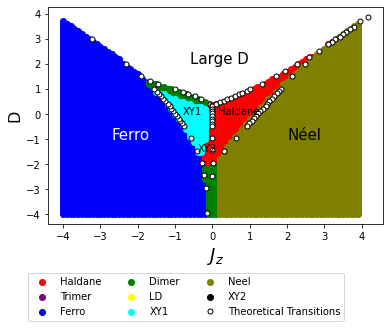

SVC - Precisão:  0.954920634920635


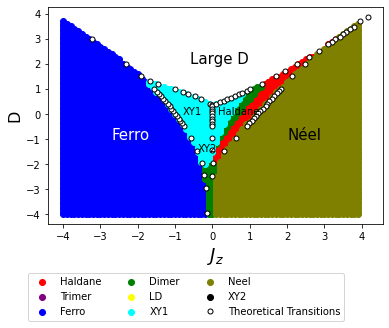

DecisionTreeClassifier - Precisão:  0.9580952380952381


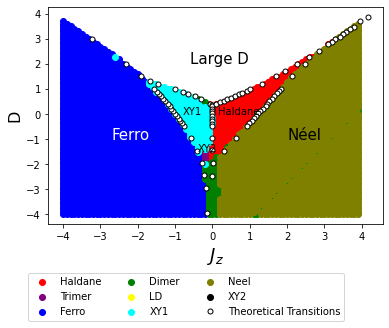

MLPClassifier - Precisão:  0.968042328042328


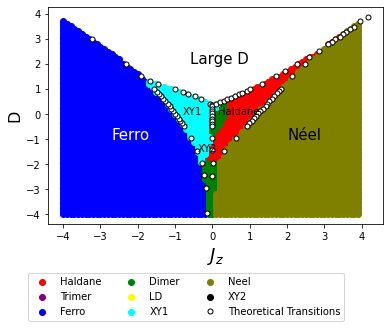

RandomForestClassifier - Precisão:  0.9733333333333334


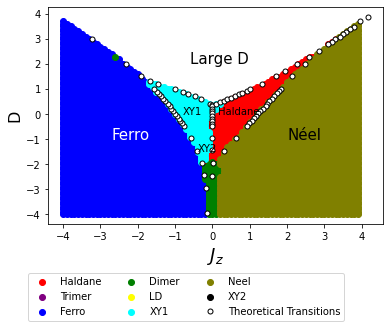

AdaBoostClassifier - Precisão:  0.0


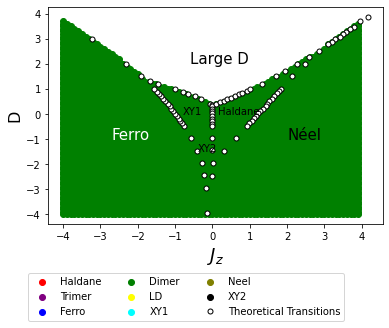

GradientBoostingClassifier - Precisão:  0.9726984126984127


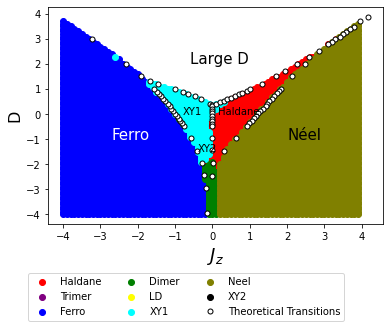

GaussianNB - Precisão:  0.9525925925925925


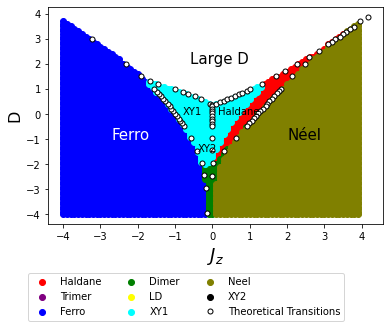

LinearDiscriminantAnalysis - Precisão:  0.9583068783068783


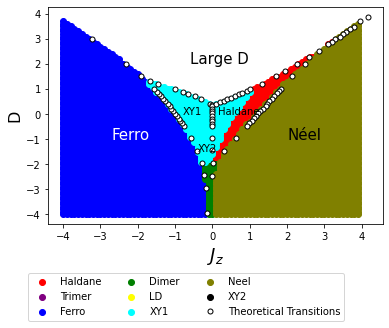

QuadraticDiscriminantAnalysis - Precisão:  0.4744973544973545


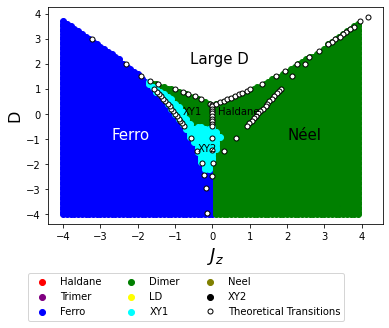

LogisticRegression - Precisão:  0.9705820105820105


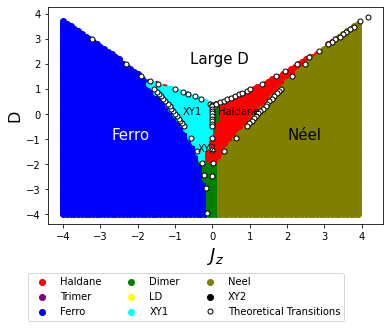

In [37]:
for classifier in classifiers:
    plotsMLTransfer(dfBond, dfBilinear, dfXXZ, dfXXZTeorico, classifier, listaNumeroFasesIgnorar=[4])

## Aplicando no Bond - Treino = (XXZ+Bilinear)

KNeighborsClassifier - Precisão:  0.7353446928247616


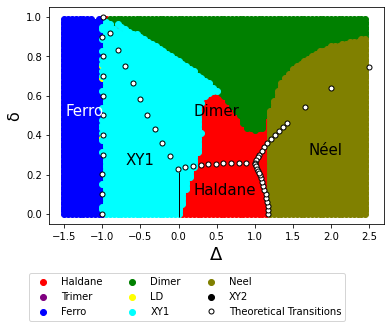

SVC - Precisão:  0.556823511020791


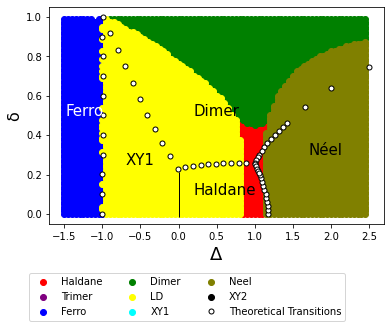

DecisionTreeClassifier - Precisão:  0.7289354384867907


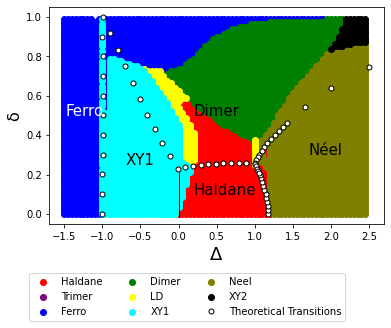

MLPClassifier - Precisão:  0.6277942785680788


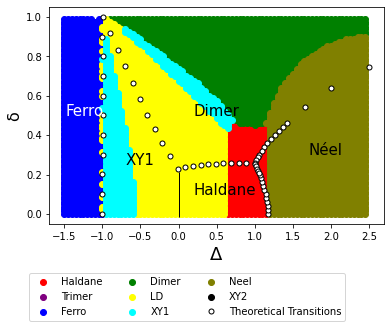

RandomForestClassifier - Precisão:  0.708300765984055


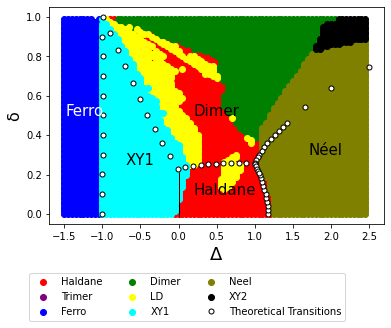

AdaBoostClassifier - Precisão:  0.3206190401750821


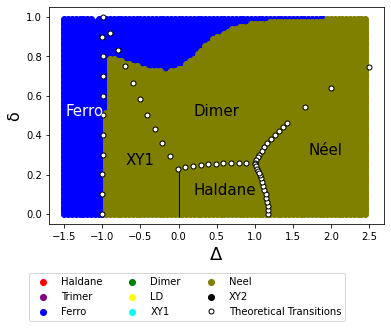

GradientBoostingClassifier - Precisão:  0.6865718305455683


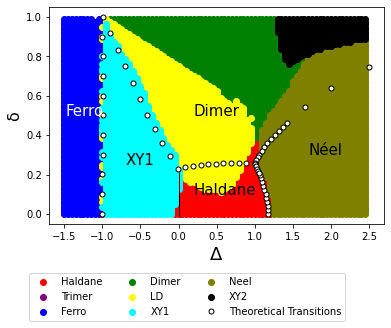

GaussianNB - Precisão:  0.7076754728779115


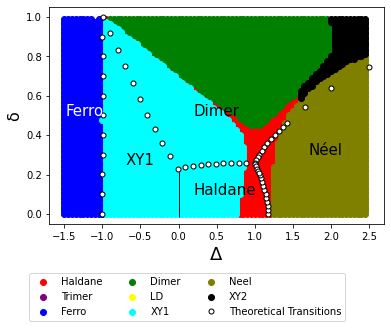

LinearDiscriminantAnalysis - Precisão:  0.6886040331405346


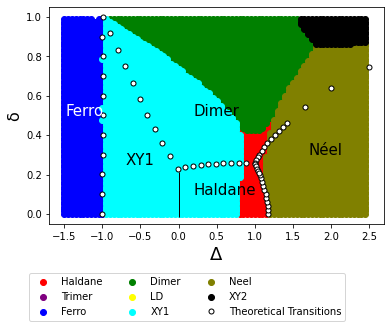

QuadraticDiscriminantAnalysis - Precisão:  0.12881037986556199


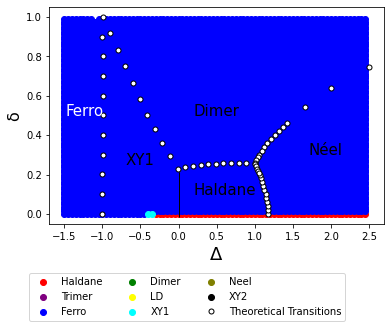

LogisticRegression - Precisão:  0.7567609817101767


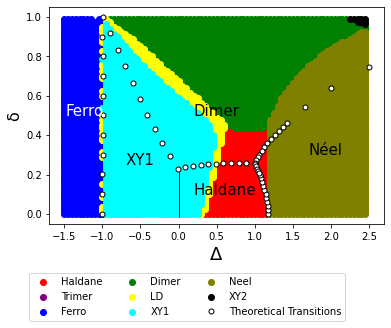

In [43]:
for classifier in classifiers:
    plotsMLTransfer(dfXXZ,dfBilinear,dfBond, dfBondTeorico, classifier)

## Aplicando no Bilinear - Treino = (XXZ+Bond)

KNeighborsClassifier - Precisão:  0.8827829594151752


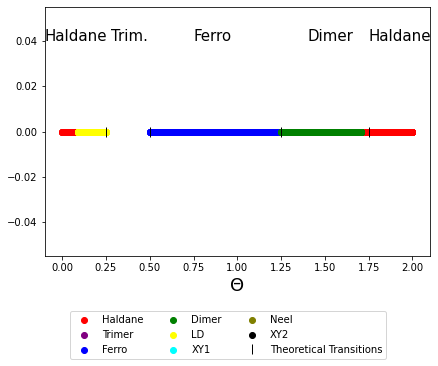

SVC - Precisão:  0.7867406100327704


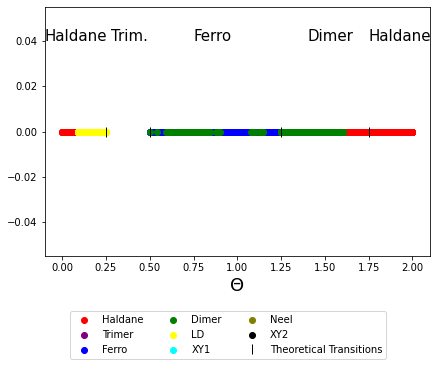

DecisionTreeClassifier - Precisão:  0.3269473153516511


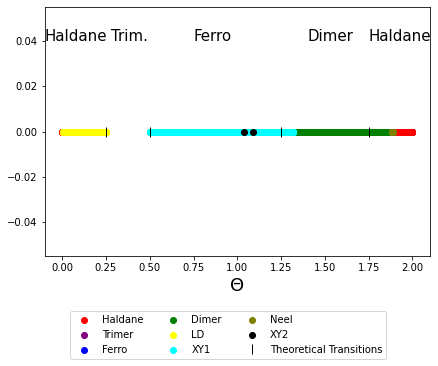

MLPClassifier - Precisão:  0.8795059238719435


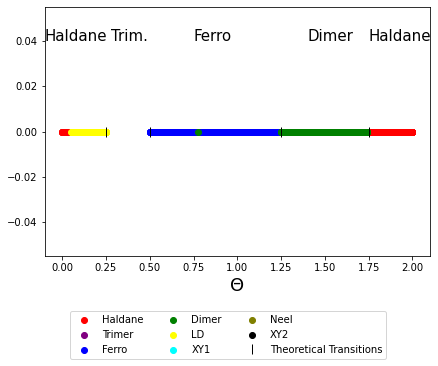

RandomForestClassifier - Precisão:  0.39097554827325437


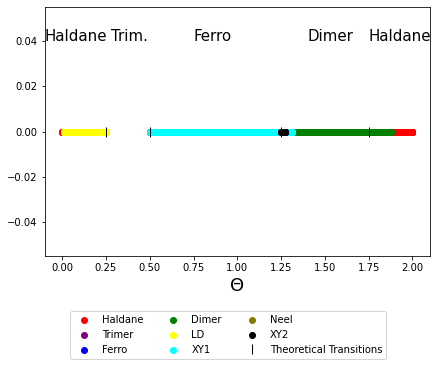

AdaBoostClassifier - Precisão:  0.2896395260902445


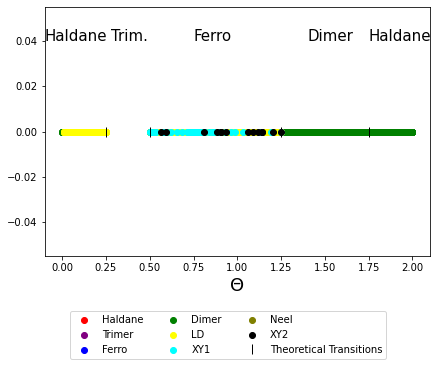

GradientBoostingClassifier - Precisão:  0.3718174943282077


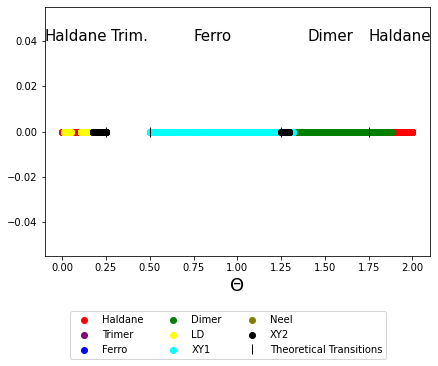

GaussianNB - Precisão:  0.44693723216536424


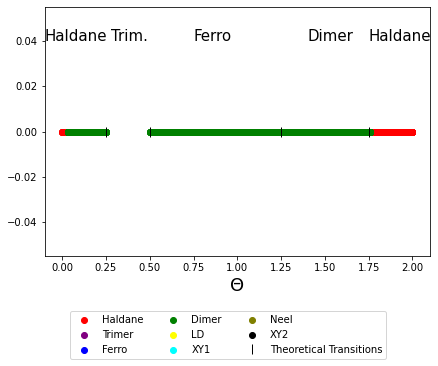

LinearDiscriminantAnalysis - Precisão:  0.21754474413914798


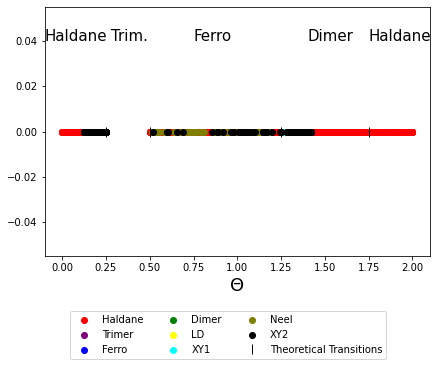

QuadraticDiscriminantAnalysis - Precisão:  0.0


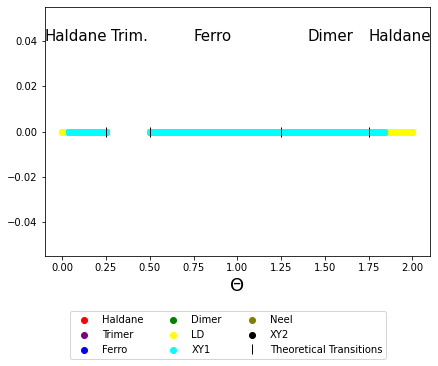

LogisticRegression - Precisão:  0.7025460045374339


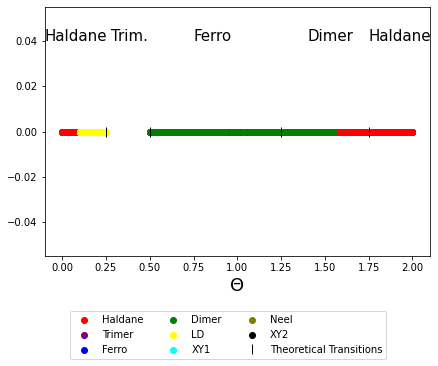

In [44]:
for classifier in classifiers:
    plotsMLTransfer(dfXXZ, dfBond, dfBilinear, dfBilinearTeorico, classifier, listaNumeroFasesIgnorar=[1])

## Variando o valor de K

Gerando os dados. No paper geramos o gráfico variando k de 1-3000. Tal range pode demorar bastante para rodar.

In [40]:
# precisaoKXXZ = list() #Lista para armazenar as precisões do XXZ variando K
# precisaoKBond = list()#Lista para armazenar as precisões do Bond variando K
# precisaoKBilinear = list()#Lista para armazenar as precisões Bilinear XXZ variando K
# valorK = list()#Lista para armazenar o valor de k variando
# for i in range(1,30):#Range no qual k vai variar - altere aqui para mudar o intervalo
#     valorK.append(i) #Insere o valor de k na lista
#     precisaoKXXZ.append(aplicarMLTransfer(dfBond,dfBilinear,dfXXZ, dfXXZTeorico,listaNumeroFasesIgnorar=[4], nKnn = i)[1]) #Armazena a precisao do XXZ para este k
#     precisaoKBond.append(aplicarMLTransfer(dfXXZ,dfBilinear,dfBond, dfBondTeorico, nKnn = i)[1])#Armazena a precisao do Bond para este k
#     precisaoKBilinear.append(aplicarMLTransfer(dfXXZ,dfBond,dfBilinear, dfBilinearTeorico, listaNumeroFasesIgnorar=[1], nKnn = i)[1])#Armazena a precisao do Bilinear para este k
# dfK = pd.DataFrame(valorK)#Adiciona os valores de k a um dataframe
# dfK["XXZ"] = precisaoKXXZ #Adiciona as precisoes coletadas do XXZ a um dataframe
# dfK["Bond"] = precisaoKBond#Adiciona as precisoes coletadas do Bond a um dataframe
# dfK["Bilinear"] = precisaoKBilinear#Adiciona as precisoes coletadas do Bilinear a um dataframe
# dfK.to_excel("dfK.xls")#Cria um arquivo excel com os dados acima. É importante principalmente no caso de um range grande (para não perder os dados)

In [41]:
# dfK = pd.read_excel("dfK.xls") #Lê o excel com os valores de k
# plt.plot(dfK[0], dfK.XXZ, label = "${\cal H}_1$") #Plota a precisão em função de K do XXZ
# plt.plot(dfK[0], dfK.Bond, label = "${\cal H}_2$")#Plota a precisão em função de K do Bond
# plt.plot(dfK[0], dfK.Bilinear, label = "${\cal H}_3$")#Plota a precisão em função de K do Bilinear
# plt.legend()#Adiciona a legenda ao gráfico
# plt.ylabel("Precision (%)")#Rotula o eixo y do gráfico
# plt.xlabel("Value of K")#Rotula o eixo x do gráfico
# plt.show()# Gera o gráfico